In [1]:
# -*- coding: utf-8 -*-
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import scipy.stats

In [2]:
# Path to signals
path = './timeseries.txt'

In [3]:
# Domains ids
ids = ['0', '20', '22', '35', '38', '54', '61', '64', '6', '70', '74', '75']

In [4]:
# Parameters for the network inference
# Tau max
tau_max = 12
# FDR rate
q = 0.03

In [5]:
# Import domains signals
ts = np.loadtxt(path)

In [6]:
# Number of signals
N = len(ts)

In [7]:
# All signals are already zero-mean
# CHECK IT
for i in range(len(ts)):
    print(np.mean(ts[i]))

5.473190239648656e-09
-9.659970601205714e-10
-1.3649639302435562e-09
6.814857672885583e-09
1.6155332732956768e-09
4.55431502034896e-09
-8.893788985698761e-09
-3.4726859271792084e-09
1.192069934826837e-10
-5.625090742406818e-09
1.74336112953218e-08
1.843350868771917e-10


In [8]:
# However signals are defined as cumulative anomalies: their standard deviation is NOT 1
# CHECK IT
for i in range(len(ts)):
    print(np.std(ts[i]))

43.88680116006965
136.40377909850065
60.11922208552029
57.87528008505874
62.21702589605089
114.58185492970722
88.76350256900211
35.836505242570894
31.596291395465204
101.47314902865504
500.6921472777807
169.96247170219584


In [9]:
# We standardize the signals for the correlation analysis
normed_ts = (ts.T/np.std(ts,axis=1)).T

In [10]:
# Check
for i in range(len(normed_ts)):
    print(np.std(normed_ts[i]))

0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
1.0


In [11]:
# Compute the correlograms for each unique pair
correlograms = []
for i in range(N):
    ts1 = normed_ts[i]
    for j in range(i+1,N):
        ts2 = normed_ts[j]
        correlograms.append(get_correlogram(ts1,ts2,tau_max,normed=True))

correlograms = np.asarray(correlograms)

In [12]:
# Compute the covariances for each unique pair
covariances = []
for i in range(N):
    ts1 = ts[i]
    for j in range(i+1,N):
        ts2 = ts[j]
        covariances.append(get_covariances(ts1,ts2,tau_max,normed=True))

covariances = np.asarray(covariances)

In [13]:
# Define the Bartlett variance as a function of the lag tau max:
# for each pair of time series we are going to have (2 tau + 1) Bartlett's variance

def bartlett_variance_tau(ts1,ts2,tau,normed=False):

    assert len(ts1) == len(ts2);
    T = len(ts1);
    ##get the correlogram of the two time series
    correlogram_ts1 = get_correlogram(ts1,ts1,T-1,normed);
    correlogram_ts2 = get_correlogram(ts2,ts2,T-1,normed);

    var = np.sum(np.multiply(correlogram_ts1,correlogram_ts2))/(T-tau);
    # set to zero (small) negative numbers
    if(var <= 0):
        var = np.random.uniform(0, 0.000001)
    return var;

In [14]:
# We want the Bartlett's variance for each unique pair of time series
bartlett = np.zeros([int(N*(N-1)/2),int(2*tau_max+1)])
k1 = 0
for i in range(N):
    ts1 = normed_ts[i]
    for j in range(i+1,N):
        ts2 = normed_ts[j]
        k2 = 0
        for tau in np.arange(-tau_max,tau_max+1,1):
            bartlett[k1,k2] = bartlett_variance_tau(ts1,ts2,tau,normed=True)
            k2 += 1
        k1 += 1    

In [15]:
# Compute the z score for every correlation

# By taking the absolute value of the correlations is like doing a 2 - tailed t-test
abs_correlograms = np.abs(correlograms)
bartlett_std = np.sqrt(bartlett)
z_scores = abs_correlograms/bartlett_std

In [16]:
# Compute all p-values for each connection 
p_vals = np.zeros([int(N*(N-1)/2),int(2*tau_max+1)])

for i in range(np.shape(z_scores)[0]):
    for j in range(np.shape(z_scores)[1]):
        ##one sided t-test
        p_vals[i,j] = 1 - scipy.stats.norm(0,1).cdf(z_scores[i,j]);

In [17]:
# Compute p_min

# Step (a)
# flatten all p_values and sort them in descending order
sorted_p_vals = sorted(p_vals.flatten())
sorted_p_vals = np.asarray(sorted_p_vals)
# How many p-values
n_p_vals = len(sorted_p_vals)
# Step (b)
# Define the line for computing the p_min
fdr_ratio = (q/n_p_vals)*np.arange(1,n_p_vals+1)

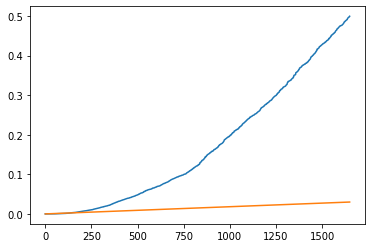

In [18]:
plt.plot(sorted_p_vals)
plt.plot(fdr_ratio)

(0, 0.01)

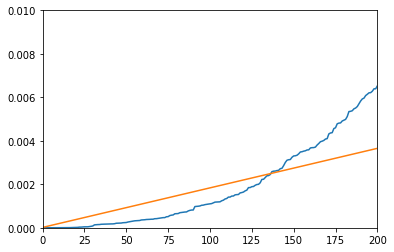

In [19]:
# Zoom
plt.plot(sorted_p_vals)
plt.plot(fdr_ratio)
plt.xlim([0,200])
plt.ylim([0,0.01])

In [20]:
# Get p_min
# (a) take the difference between fdr_ratio[i] and sorted_p_vals[i]
difference = fdr_ratio-sorted_p_vals
# (b) take only the positive entries
positive_vals = sorted_p_vals[difference>0]
# (c) p_min is the last entry
p_min = positive_vals[-1]

In [21]:
# pairs is an array with all possible pairs
# It has the same order of the arrays correlations or covariances

# E.g., correlations[0] is the correlogram between the pair of domains in pairs[0]

pairs = []
for i in range(N):
    id1 = ids[i]
    for j in range(i+1,N):
        id2 = ids[j]
        pairs.append([id1,id2])
        
pairs = np.array(pairs)       

In [22]:
# We set to zero all the correlations with p value > p_min
correlograms[p_vals>p_min] = 0

In [23]:
def edge_inference(corr_matrix,cov_matrix,bartlett_std_matrix,domains_pair):
    
    # input: (a) correlograms
    #        (b) covariances
    #        (c) bartlett standard deviations
    #        (d) all pairs of domains (same order of correlograms)
    
    # output list of edges.
    #        Each edge have the following format
    #        [from domain a, to domain b, tau_min, tau_max, tau*, r*, weight]
    #        where 
    
    #       r* is the max significant correlation
    #       tau* is the lag correspondent to r*
    
    #       [tau_min,tau_max] defines the range of lags associated with significant correlations
    #       in the interval [r*-bartlett std(r*),r*+bartlett std(r*)]
    
    #       weight is the link weight: covariance at tau*
    
    
    # Define an array with the lags
    lags = np.arange(-tau_max,tau_max+1,1)
    
    # initialize the array that will hold the edges
    edges = []
    
    for i in range(len(corr_matrix)):
        
        # If the correlogram is all zeros -> no signifinant correlations -> skip it
        if np.sum(np.abs(corr_matrix[i])) == 0:
        
            continue
            
        else:
            # Correlograms of link domains_pair[i]
            correlogram = corr_matrix[i]
            # Covariances of link domains_pair[i]
            covariance = cov_matrix[i]
            # Bartletts standard deviations of the correlogram relative to domains_pair[i]
            bartlett_sigmas = bartlett_std_matrix[i]
        
            # Compute the max in absolute value
            max_corr = max(correlogram,key=abs)
            # Find the correspondent bartlett std
            std_max = bartlett_sigmas[correlogram==max_corr][0]
            # Keep only the values that are inside 1 sigma of the max
            constraints = np.logical_and(correlogram<=max_corr+std_max, correlogram>=max_corr-std_max)
            # Find the lags associated with the correlations respecting correlogram
            lags_connection = lags[constraints]
            # Min and max lag 
            lag_min = lags_connection[0]
            lag_max = lags_connection[-1]
            # Lag tau* correspondent to r*
            lag_star = lags[correlogram==max_corr][0]
            # Weight: covariance at Lag tau*
            weight = covariance[correlogram==max_corr][0]
            
            edge = [pairs[i][0],pairs[i][1],lag_min,lag_max,lag_star,max_corr,weight]
            
        edges.append(edge)    
        
    return edges

In [24]:
network = edge_inference(correlograms,covariances,bartlett_std,pairs)

In [50]:
# Compute the strengths
indices_net = np.array(network)[:,0:2]

strength_list = []

for i in range(len(ids)):
    
    # id considered
    id_domain = ids[i]
    
    if len(np.where(indices_net==ids[i])[0]) == 0:
    
        strength_list.append([id_domain,0])
        
    else:
        
        # Positions of the index in the net
        pos = np.where(indices_net==ids[i])[0]
        
        # Initialize a sublist where we hold the weights associated to each connections
        sublists = []
        
        for j in range(len(pos)):
            
            sublists.append(network[pos[j]][6]) # the weight is entry 6 in the network array
            
        strength_list.append([id_domain,np.sum(np.abs(sublists))])

In [45]:
len(np.where(indices_net==ids[0])[0])==0

True

In [46]:
network

[['20', '22', -1, 4, 1, -0.4761034816622015, -3904.281406571045],
 ['20', '54', 0, 1, 0, -0.306732434084665, -4794.043300568529],
 ['20', '61', -10, -3, -6, 0.40693550045107235, 4927.043679229831],
 ['20', '70', 3, 6, 4, 0.3591438501577918, 4971.025316838217],
 ['20', '74', -3, 3, 0, -0.658810209804914, -44994.300426043104],
 ['20', '75', -12, -5, -8, 0.4250177000215324, 9853.407813032309],
 ['22', '54', -2, 3, 0, 0.34931485882624314, 2406.280549927201],
 ['22', '61', -8, -1, -6, -0.34119019482853946, -1820.724873194928],
 ['22', '70', -3, 3, 0, -0.303521308318714, -1851.6277295055056],
 ['22', '74', -5, 1, -2, 0.5961123306321922, 17943.70983894848],
 ['22', '75', -12, -7, -11, -0.34838966013687456, -3559.849582490768],
 ['35', '54', 8, 8, 8, 0.23287601382991405, 1544.3072596373993],
 ['38', '54', 0, 6, 0, 0.2831577818142795, 2018.6154700520883],
 ['54', '74', -6, 0, -3, 0.5950186168591978, 34136.35786896345],
 ['54', '75', -1, 7, 3, 0.3670833257467904, 7148.806543181031],
 ['61', '74'

In [51]:
strength_list

[['0', 0],
 ['20', 73444.10194228303],
 ['22', 31486.473980637933],
 ['35', 1544.3072596373993],
 ['38', 2018.6154700520883],
 ['54', 52048.4109923297],
 ['61', 32000.2878824981],
 ['64', 0],
 ['6', 0],
 ['70', 25005.18390692323],
 ['74', 161864.0166081932],
 ['75', 55291.70850136917]]